# Numpy-based Neural Network engine from scratch

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/m12sl/dl-hse-2020/blob/master/01-introduction/numpy%20neural%20networks%20from%20scratch.ipynb)



В этой тетрадке мы напишем собственный простенький фреймворк для создания и обучения нейронной сети.

**Цели тетрадки**

1. Понять, что лежит в основе DL фреймворков
2. Разобраться с бекпропом на примере простых слоев
3. Встретить характерные для векторизованных вычислений ошибки
4. Вспомнить особенности операций с плавающей точкой
5. Попробовать тестировать код сразу


**План работы**

0. Обсудить векторизацию вычислений и договориться о формате входных-выходных данных
1. Рассмотреть как высокоуровнево устроен движок для сеток
2. Реализовать несколько базовых слоев
3. Натренировать простую сеть на задаче MNIST

In [2]:
%matplotlib inline
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm

# Векторизация вычислений (batchification)

<img src="https://github.com/m12sl/dl-hse-2020/raw/master/01-introduction/img/graph_vector.png" crossorigin="anonymous"/>

В современных компьютерах выгодно объединять данные к которым будет применена одна и та же операция в вектора и батчи. Для вычисления длин нескольких векторов их, как правило, выгодно склеить в массив (numpy.ndarray) и применить векторизованную операцию (все numpy-операции работают с многомерными массивами).


На практике во всех фреймворках для DL (да и для ML) работают с данными упакованными в батчи: 
многомерные массивы с размерами `[batch_size, channels, *spatial_dimensions]` -- такие массивы называются тензорами. 

Подразумевается, что примеры в батче независимы друг от друга и никак не влияют друг на друга (за исключением некоторых нормализаций и специальных трюков).


<img src="https://github.com/m12sl/dl-hse-2020/raw/master/01-introduction/img/graph_batched.png" crossorigin="anonymous"/>


Предлагается реализовать простой движок для обучения простых нейронных сетей (MLP, Multi Layer Perceptron).

Класс для обходов вычислительного графа предлагается взять таким:

In [3]:
class SomeNetwork:
    def __init__(self, layers):
        self.layers = layers
    
    def forward(self, input):
        x = input
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, grads):
        for layer in self.layers[::-1]:
            grads = layer.backward(grads)
        return grads

Слои -- это объекты с двумя методами (`forward`, `backward`) и конструктором (`__init__`).

**Для простоты предлагается вычисление градиентов по весам и их применение объединить с backward-проходом.**

Операция `Wx + b` формально имеет три входа: входной тензор $x$ и веса: $W$ и $b$. Мы разместим веса в слое, так что слой на прямом проходе будет иметь только один вход `x`, а на обратно выдавать градиенты $\frac{\partial L}{\partial x}$.


**Посмотрите внимательно на прототип слоя, вам потребуется реализовать Linear и ReLU на основе него:**

In [4]:
# Это на самом деле identity
class Layer:
    def forward(self, input):
        # store something if needed
        return input
    
    def backward(self, grads):
        # apply grads here if any
        return grads

In [5]:
# Сеть которая не делает ничего:
network = SomeNetwork([Layer(), Layer()])

x = np.random.random(size=(3, 5))
output = network.forward(x)
assert output.shape == (3, 5)

y = np.ones((3, 5))
grads = network.backward(y)
assert grads.shape == (3, 5)

В качестве сети возьмем самую простую: Multilayer Perceptron (MLP).

<img src="https://github.com/m12sl/dl-hse-2020/raw/master/01-introduction/img/graph_mlp.png" crossorigin="anonymous"/>


Нам потребуется реализовать следующие слои:

```
Linear
Relu
```

Целевой задачей возьмем многоклассовую классификацию, мы хотим, чтобы наша сеть для каждого входного примера предсказывала распределение вероятностей $q_i$.

Функция ошибки должна отражать близость распределения $q$ к известным правильным ответам. В этом нам поможет кросс-энтропийная функция ошибки (перекрестная энтропия):
$$
H(p, q) = - \sum \limits_{i} p_i \log q_i 
$$

Эта формула описывает близость между двумя распределениями вероятностей:
 - $i$ --- номер класса,
 - $p_i$ --- правильная вероятность класса (единица, еcли правильная метка i, ноль, если нет)
 - $q_i$ --- предсказанная вероятность (выход сети).

## Linear Layer

Синонимы: Linear, Dense, FullyConnected, Projection:

Математическое действие над вектором признаков:
$$\mathbf{y} = W \mathbf{x} + \mathbf{b}$$

Пусть 
$\mathbf{x} \in \mathbb{R}^n$
$\mathbf{y}\in \mathbb{R}^m$

**Какую размерность должен иметь $W$ и $b$?**

Давайте теперь реализуем векторизованный вариант слоя: `y = f(x, W, b)`

```python
x.shape == (batch_size, in_channels)
y.shape == (batch_size, out_channels)
```

**0.5 балла** Напишите код для вычисления прямого прохода и обратного в векторизованной форме.
Шаг градиентного спуска предлагается совместить с обратным проходом.

Веса $W, b$ считаем принадлежащими слою, инициализируем при создании, во время обратного прохода возвращаем градиенты только за входной тензор.

**NB: нас не интересует строгое соответствие математической нотации, она годится для работы с векторами. Мы же работаем с данными собранными в батчи.**

Для простоты движка важно, чтобы операции получали и возвращали данные в правильном формате. 
В данном случае -- это numpy.ndarray с размерностями `[bs, dim]`.

In [103]:
# Реализуйте линейный слой
# y = Wx + b

class Linear(Layer):
    def __init__(self, in_channels, out_channels, learning_rate=0.1):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.W = np.random.randn(in_channels, out_channels) * 0.01
        self.b = np.zeros(out_channels)
        self.learning_rate = learning_rate
        # for debug purpose
        self.grad_W = None
        self.grad_b = None
        self.grad = None
    
    def forward(self, x):
        y = np.dot(x, self.W)+self.b
        self.saved_input = x
#         print(self.saved_input[0])
        self.bs = x.shape[0]
        return y
    
    def backward(self, grad):
        grad_W = np.dot(self.saved_input.T,grad)
        grad_b = np.sum(grad, axis=0)
        grad = np.dot( grad, self.W.T)
        
        self.W = self.W - grad_W * self.learning_rate
        self.b = self.b - grad_b * self.learning_rate
        
        self.saved_input=None
        self.grad_W = grad_W
        self.grad_b = grad_b
        self.grad = grad
        return grad

    
# тесты для самопроверки
linear = Linear(5, 7)

x = np.random.random(size=(3, 5))
assert linear.forward(x).shape == (3, 7), "Forward pass shape mistmatch"

y = np.random.random(size=(3, 7))
grad_x = linear.backward(y)
assert grad_x.shape == (3, 5)
assert linear.grad_W.shape == linear.W.shape
assert linear.grad_b.shape == linear.b.shape

## ReLU Layer

Это простая поэлементная операция, записывается как $f(x) = max(x, 0)$.

**NB: активационные слои не меняют размер тензора**

**0.3 балла**

In [104]:
class ReLU(Layer):
    def forward(self, input_):
        self.saved =input_
        return np.maximum(input_, 0)
    
    def backward(self, grad):
        
        return (self.saved>0).astype(int)*grad
    
relu = ReLU()
x = np.random.normal(size=(3, 5))
assert relu.forward(x).shape == (3, 5)
assert np.all(relu.forward(x) >= 0.0)

y = np.random.normal(size=(3, 5))
grads = relu.backward(y)
assert grads.shape == (3, 5) 

approx = (relu.forward(x + 1e-5) - relu.forward(x)) / 1e-5
# print(approx)
relu.forward(x)
assert np.allclose(relu.backward(np.ones_like(x)), approx)

Для подсчета ошибки нам необходимы предсказания сети и правильные ответы.

Для простоты подсчет ошибки и градиентов вынесены в отдельные функции вместе с вычислением вероятностей (softmax).

Каждая из функций ожидает на вход логиты -- тензор с размерами `[bs, num_classes]`.

`softmax_crossentropy_with_logits` возвращает одно число -- величину ошибки.

`grad_softmax_crossentropy_with_logits` возвращает тензор размером `[bs, num_classes]` с градиентами по логитам.


In [105]:
def softmax_crossentropy_with_logits(logits, reference_answers):
    """Compute crossentropy from logits[batch, n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy.mean()

def grad_softmax_crossentropy_with_logits(logits, reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

## Data Handling
Для работы с данными во всех фреймворках есть Dataset/Dataloader классы.

Мы будем разбирать pytorch Data API отдельно, а пока предлагается воспользоваться готовым кодом:

In [106]:
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST

# в FashionMNIST уже есть код, который грузит данные и читает их в PIL.Image, мы конвертируем их в вектора.
# Непосредственно с картинками мы будем работать позже
def transform(pil_image):
    return np.asarray(pil_image).astype(np.float32).reshape(-1) / 255.0


def numpy_collate_fn(batch):
    x, y = list(zip(*batch))
    return np.array(x).astype(np.float32), np.array(y).astype(np.int32)


# dataset умеет выдавать отдельные семплы с метками
train_dataset = FashionMNIST("./tmp", train=True, download=True, transform=transform)
test_dataset = FashionMNIST("./tmp", train=False, download=True, transform=transform)
# dataloader выдает целые батчи и поддерживает итерирование
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32, collate_fn=numpy_collate_fn)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=32, collate_fn=numpy_collate_fn)

(784,) 9
float32 int32
(32, 784) (32,)


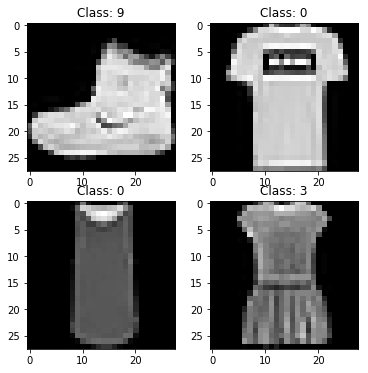

In [107]:
# dataset возвращает отдельные семплы
print(train_dataset[11][0].shape, train_dataset[11][1])

# dataloader целые батчи
for x, y in train_loader:
    print(x.dtype, y.dtype)
    print(x.shape, y.shape)
    break

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title(f"Class: {train_dataset[i][1]}")
    plt.imshow(train_dataset[i][0].reshape(28, 28),cmap='gray');

## Train Loop

Теперь все готово чтобы сделать сеть и проучить ее.
Если все реализовано правильно, можно ожидать точности на валидации ~0.86+.

Кросс-энтропийный лосс не слишком показательная величина, но если он должен оказаться ~0.4 на валидации.

In [108]:
network = SomeNetwork([
    Linear(784, 100),
    ReLU(), 
    Linear(100, 50),
    ReLU(),
    Linear(50, 10),
])

epochs = 20
overall_logs=[]
for epoch in range(epochs):
    for x, y in tqdm(train_loader):
        logits = network.forward(x)
        loss = softmax_crossentropy_with_logits(logits, y)
        acc = np.mean(np.argmax(logits, axis=-1) == y)
        grads = grad_softmax_crossentropy_with_logits(logits, y)
        network.backward(grads)
        
    logs = defaultdict(list)
    for x, y in tqdm(test_loader):
        logits = network.forward(x)
        loss = softmax_crossentropy_with_logits(logits, y)
        acc = np.mean(np.argmax(logits, axis=-1) == y)
        logs['loss'].append(loss)
        logs['acc'].append(acc)
        
    for k, v in logs.items():
        print(k, np.mean(v))
    overall_logs.append([epoch]+[np.mean(x) for x in logs.values()])
    

loss 0.5065506872001109
acc 0.8178913738019169


loss 0.4316469308876094
acc 0.8436501597444089


loss 0.4125559449193015
acc 0.8483426517571885


loss 0.3826618878532309
acc 0.8644169329073482


loss 0.39585698809374475
acc 0.854632587859425


loss 0.3618654849283156
acc 0.8710063897763578


loss 0.3964211105069014
acc 0.8556309904153354


loss 0.355100857318516
acc 0.869408945686901


loss 0.34926660065747267
acc 0.8739017571884984


loss 0.3364668140304671
acc 0.8795926517571885


loss 0.35202455913710906
acc 0.8705071884984026


loss 0.3565709444375521
acc 0.8698083067092651


loss 0.3678399105428448
acc 0.8707068690095847


loss 0.33113216759550995
acc 0.8831869009584664


loss 0.3517091862483386
acc 0.8763977635782748


loss 0.3395721352358629
acc 0.880491214057508


loss 0.3314014634847424
acc 0.8890774760383386


loss 0.3400167336838464
acc 0.8834864217252396


loss 0.3375782323089449
acc 0.8876797124600639


loss 0.3447237414504165
acc 0.882388178913738


**0.1 балл**. Постройте графики обучения: метрики от количества шагов.


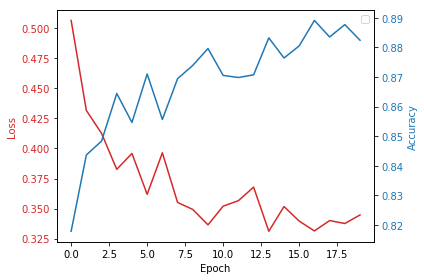

In [109]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Epoch')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_ylabel('Loss', color='tab:red')  # we already handled the x-label with ax1
ax1.plot(
    [x[0] for x in overall_logs],
    [x[1] for x in overall_logs],
    color='tab:red'
)
ax1.tick_params(axis='y', labelcolor='tab:red')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Accuracy', color='tab:blue')  # we already handled the x-label with ax1
ax2.plot(
    [x[0] for x in overall_logs],
    [x[2] for x in overall_logs],
    color='tab:blue'
)
ax2.tick_params(axis='y', labelcolor='tab:blue')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend()
plt.show()



**0.1 балл**. Выведите пример картинок, предсказаний и правильных ответов.

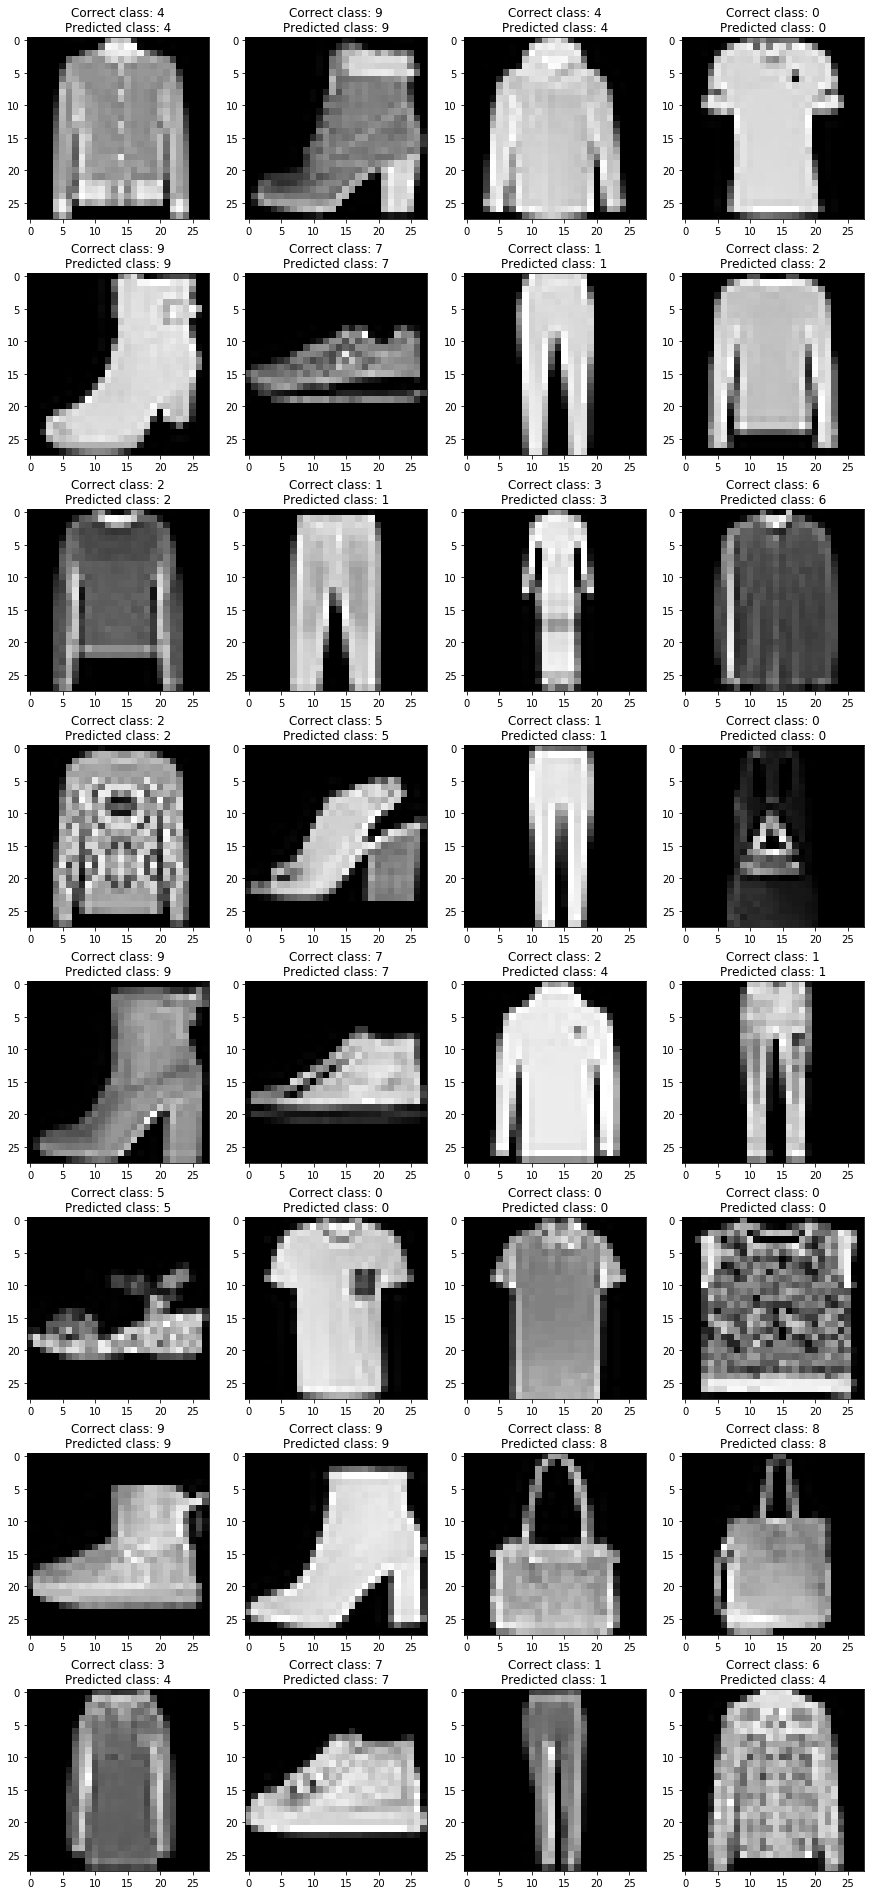

In [148]:

for i in test_loader:
    x,y = i
    break
logits = network.forward(x)
ans = logits.argmax(axis=1)


fig, ax = plt.subplots(nrows=8,ncols=4, figsize=(15,34))
for i in range(32):
    
    
    ax[i//4][i%4].imshow(x[i].reshape(28,28),cmap='gray')
    ax[i//4][i%4].set_title(f'Correct class: {y[i]}\nPredicted class: {ans[i]}')
    